In [535]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_percentage_error

In [536]:
df = pd.read_csv("/Users/sushrutghimire/Downloads/multiTimeline (1).csv", header=0)

In [537]:
df_prophet = df.rename(columns={'Month': 'ds', 'ice cream: (India)': 'y'})

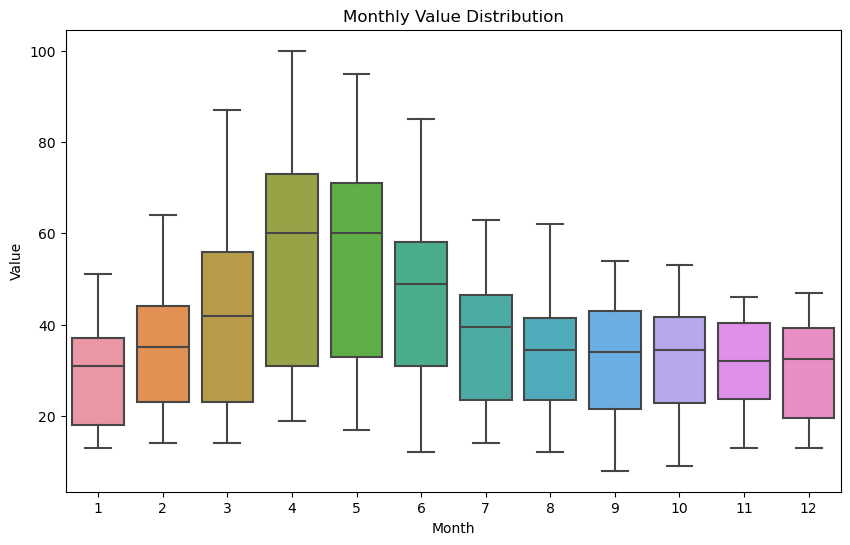

In [538]:
# Convert 'ds' to datetime format
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])

# Extract the month from 'ds'
df_prophet['month'] = df_prophet['ds'].dt.month

# Create a box plot for the monthly value distribution
plt.figure(figsize=(10, 6))
sns.boxplot(x='month', y='y', data=df_prophet)
plt.xlabel('Month')
plt.ylabel('Value')
plt.title('Monthly Value Distribution')
plt.show()


In [539]:
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'], format='%Y-%m-%d')
df_prophet.set_index('ds', inplace=True)
# df_prophet.index.freq = 'M'
df_prophet = df_prophet['2012-01-01':]

In [540]:
df_prophet

,y,month
ds,,
2012-01-01,33,1
2012-02-01,35,2
2012-03-01,47,3
2012-04-01,60,4
2012-05-01,65,5
...,...,...
2024-02-01,51,2
2024-03-01,66,3
2024-04-01,85,4


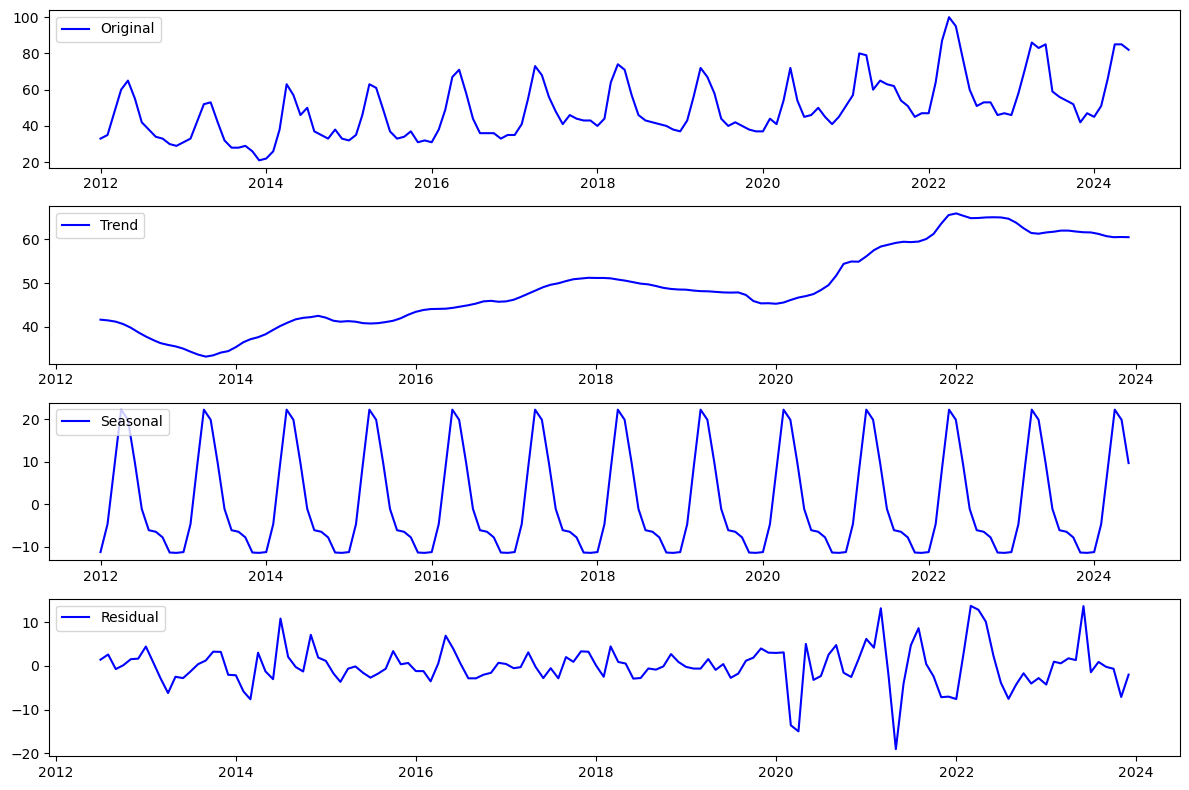

In [541]:
# Perform seasonal decomposition
decomposition = seasonal_decompose(df_prophet['y'], model='additive')  # Assuming yearly seasonality

# Plot the components
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(df_prophet['y'], label='Original', color='blue')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend', color='blue')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal', color='blue')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(decomposition.resid, label='Residual', color='blue')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


In [542]:
print(df_prophet.to_string())

              y  month
ds                    
2012-01-01   33      1
2012-02-01   35      2
2012-03-01   47      3
2012-04-01   60      4
2012-05-01   65      5
2012-06-01   55      6
2012-07-01   42      7
2012-08-01   38      8
2012-09-01   34      9
2012-10-01   33     10
2012-11-01   30     11
2012-12-01   29     12
2013-01-01   31      1
2013-02-01   33      2
2013-03-01   42      3
2013-04-01   52      4
2013-05-01   53      5
2013-06-01   42      6
2013-07-01   32      7
2013-08-01   28      8
2013-09-01   28      9
2013-10-01   29     10
2013-11-01   26     11
2013-12-01   21     12
2014-01-01   22      1
2014-02-01   26      2
2014-03-01   38      3
2014-04-01   63      4
2014-05-01   57      5
2014-06-01   46      6
2014-07-01   50      7
2014-08-01   37      8
2014-09-01   35      9
2014-10-01   33     10
2014-11-01   38     11
2014-12-01   33     12
2015-01-01   32      1
2015-02-01   35      2
2015-03-01   46      3
2015-04-01   63      4
2015-05-01   61      5
2015-06-01 

In [543]:
df_prophet.reset_index(drop=False, inplace=True)


In [544]:
train_size = int(len(df_prophet) * 0.8)  # 80% training, 20% testing
train = df_prophet[:train_size]
test = df_prophet[train_size:]

In [599]:
holiday_df = pd.DataFrame({
    'holiday': 'HotnessSpike',
    'ds': pd.to_datetime([
        '2012-05-01',
        '2017-04-01',
        '2022-04-01'  
    ]),
    'lower_window': 0,
    'upper_window': 1,
})

In [600]:

prophet_model = Prophet(
    seasonality_mode='multiplicative',
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_prior_scale=10.0,
    changepoint_prior_scale=0.05,
    holidays_prior_scale=10,
    holidays = holiday_df,
    changepoint_range = 0.8
)

In [601]:
prophet_model.fit(train)

03:11:50 - cmdstanpy - INFO - Chain [1] start processing
03:11:50 - cmdstanpy - INFO - Chain [1] done processing


In [602]:
future = prophet_model.make_future_dataframe(periods=len(test), freq='MS')

In [603]:
forecast = prophet_model.predict(future)

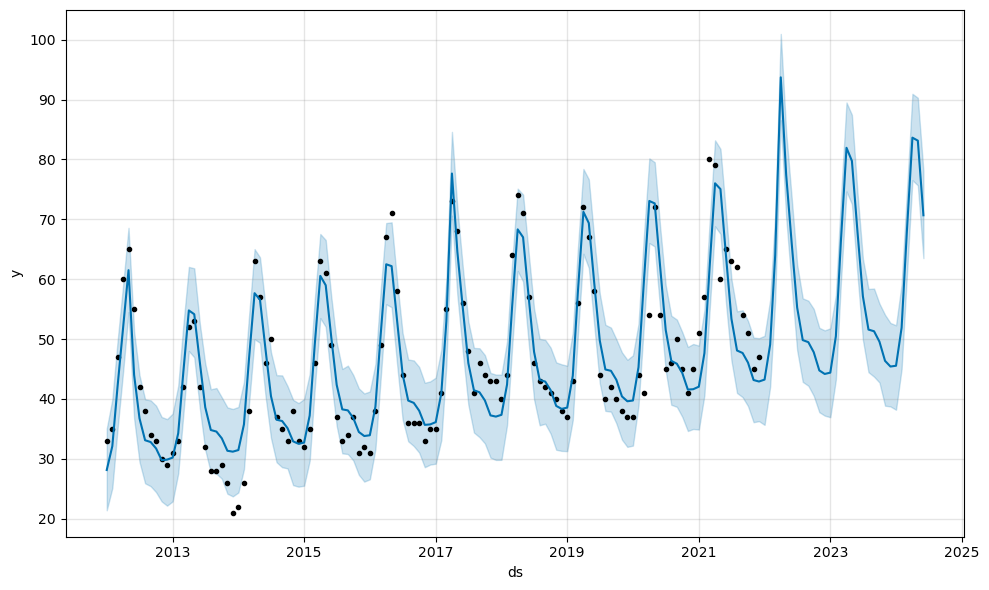

In [604]:
fig = prophet_model.plot(forecast)

MAPE: 0.08


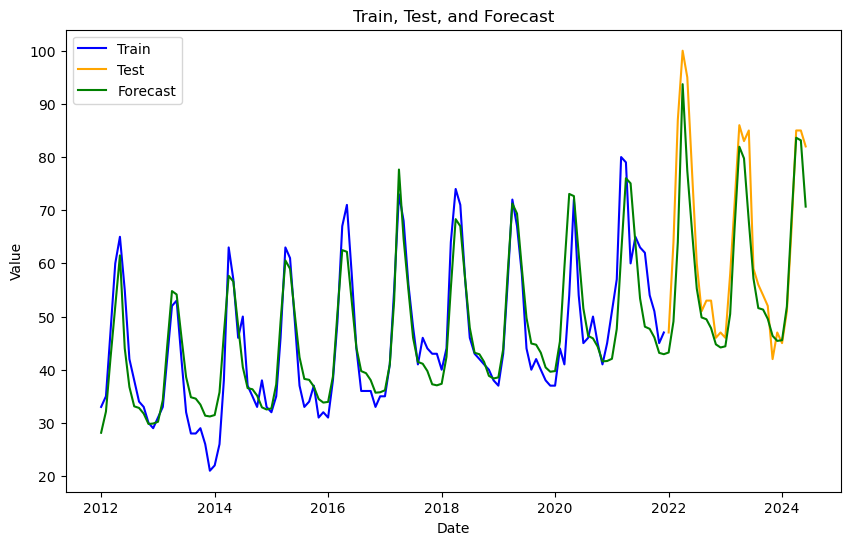

In [605]:

forecast_test = forecast[-len(test):]


mape = mean_absolute_percentage_error(test['y'], forecast_test['yhat'])
print(f'MAPE: {mape:.2f}')

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(train['ds'], train['y'], label='Train', color='blue')
plt.plot(test['ds'], test['y'], label='Test', color='orange')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='green')
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Train, Test, and Forecast')
plt.show()

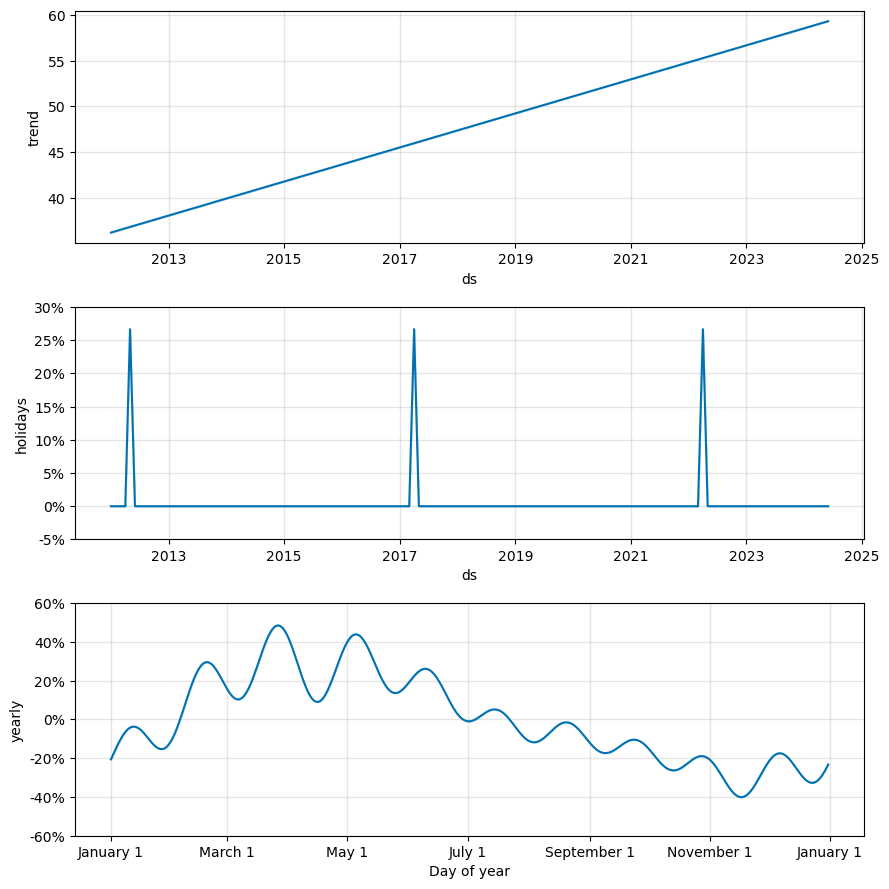

In [606]:
fig = prophet_model.plot_components(prophet_model.predict(df_prophet))
plt.show()